In [53]:
#Run if your nvidia is old
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [54]:
import numpy as np 
from keras import layers, models
from keras.utils import to_categorical
from keras.datasets import mnist
import matplotlib.pyplot as plt



## Tensorflow + Keras libraries
import tensorflow as tf
import tf_keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l2, l1

import tensorflow_model_optimization as tfmot

## Pruning
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning

## Quantization
from qkeras import *

## Knowledge Distillation
from src.distillationClassKeras import *

## Metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import shuffle

## Pre-processing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder

## Training
from sklearn.model_selection import train_test_split

In [55]:
from tensorflow.keras.optimizers import RMSprop

In [56]:
(train_data, train_labels) , (test_data, test_labels) = mnist.load_data()

In [57]:
train_data.shape 

(60000, 28, 28)

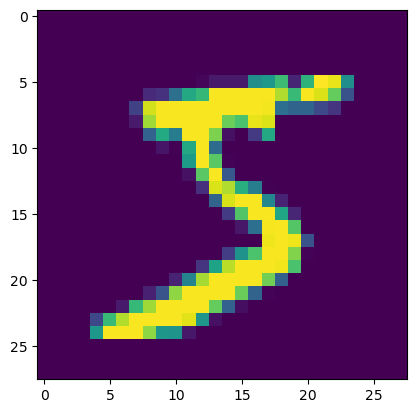

In [58]:
plt.imshow(train_data[0]) #mostrar la primera imagen

In [76]:
# Define the hyperparameters for the teacher model
lr = 0.01
neurons_teacher = [64, 32]

In [77]:
def teacher_topology(bestHP):

    teacher = keras.models.Sequential(
        [
            keras.Input(shape=(28*28,)),
            

            Dense(bestHP[0], activation='relu', kernel_regularizer=l2(0.001), name='fc1'),
            Dense(bestHP[1], activation='relu', kernel_regularizer=l2(0.001), name='fc2'),
            Dropout(0.1, name='drop1'),
            
            Dense(10, activation='softmax', name='output'),
        ],
        name="teacher_MLP",
    )

    teacher.summary()
    return teacher


In [78]:
 
def build_teacher(neurons_teacher):

    model = teacher_topology(neurons_teacher)
       
    opt = Adam(lr)
    
    model.compile(optimizer=opt, loss=['categorical_crossentropy'], metrics=['accuracy'])
    
    return model

In [79]:
teacher_model = build_teacher(neurons_teacher) 

Model: "teacher_MLP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ fc1 (Dense)                     │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,650 (205.66 KB)

 Trainable params: 52,650 (205.66 KB)

 Non-trainable params: 0 (0.00 B)

In [80]:
#entrenando el modelo
#cambiando´rimero la forma de los datos
x_train = train_data.reshape((60000,28*28))#bajar a dos dimencionas para facilitar la red neuronal
x_train = x_train.astype('float32')/255 #es mas facil manjear float y /255 es el numero maximo para que me de numero de 0 a 1

x_test = test_data.reshape((10000,28*28))#bajar a dos dimencionas para facilitar la red neuronal
x_test = x_test.astype('float32')/255 #es mas facil manjear float y /255 es el numero maximo para que me de numero de 0 a 1

In [81]:
x_train = train_data.astype("float32") / 255.0
x_test  = test_data.astype("float32") / 255.0

In [82]:
x_train = x_train.reshape((x_train.shape[0], 28*28))
x_test  = x_test.reshape((x_test.shape[0], 28*28))

In [83]:
#hacer una transformacion a los labels

y_train = to_categorical(train_labels, num_classes=10)
y_test  = to_categorical(test_labels, num_classes=10)

In [84]:
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train,
    test_size=0.1,     # 10% validación
    random_state=42,
    shuffle=True
)

In [85]:
callbacks = [
            tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=1, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor=0.4, patience=3, verbose=1)
            ] 

history_teacher  = teacher_model.fit(x=x_train, y=y_train,
                  validation_data=(x_test, y_test), 
                  batch_size = 64,
                  epochs=5,
                  callbacks = [callbacks],
                  verbose=1
                  )   

Epoch 1/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8944 - loss: 0.5390 - val_accuracy: 0.9344 - val_loss: 0.4135 - learning_rate: 0.0100
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9193 - loss: 0.4648 - val_accuracy: 0.9352 - val_loss: 0.4075 - learning_rate: 0.0100
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9206 - loss: 0.4465 - val_accuracy: 0.9250 - val_loss: 0.4239 - learning_rate: 0.0100
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9231 - loss: 0.4362 - val_accuracy: 0.9225 - val_loss: 0.4438 - learning_rate: 0.0100
Epoch 5/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9256 - loss: 0.4241 - val_accuracy: 0.9280 - val_loss: 0.3905 - learning_rate: 0.0100
Restoring model weights from the end of the best epoch: 5.


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


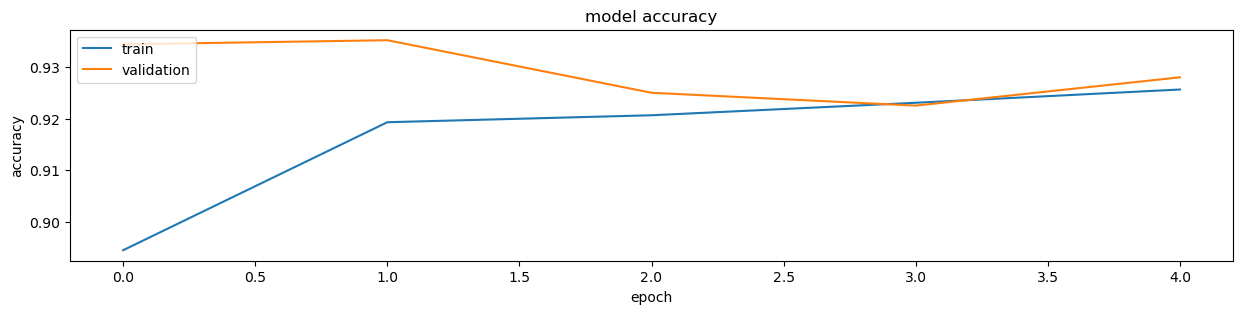

<Figure size 640x480 with 0 Axes>

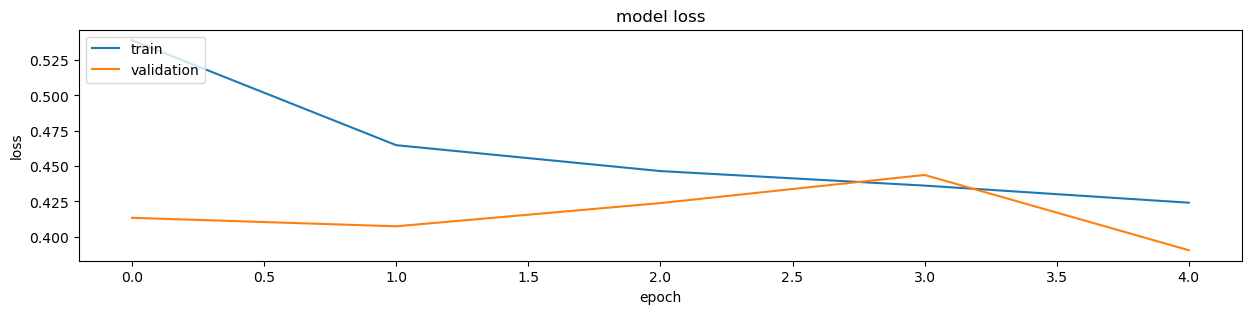

In [86]:
print(history_teacher.history.keys())

## Plot for accuracy
plt.figure(figsize=(15,3))
plt.plot(history_teacher.history['accuracy'])
plt.plot(history_teacher.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.figure()

## Plot for loss
plt.figure(figsize=(15,3))
plt.plot(history_teacher.history['loss'])
plt.plot(history_teacher.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


<Figure size 700x700 with 0 Axes>

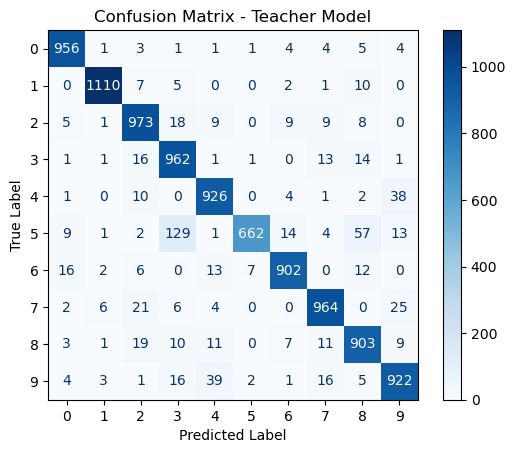

In [87]:
# 1. Predecir probabilidades
y_pred_probs = teacher_model.predict(x_test)   # usa x_test de MNIST

# 2. Convertir a etiquetas predichas
y_pred = np.argmax(y_pred_probs, axis=1)

# 3. Convertir y_test one-hot a etiquetas reales
y_true = np.argmax(y_test, axis=1)

# 4. Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# 5. Plot limpio
plt.figure(figsize=(7, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix - Teacher Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

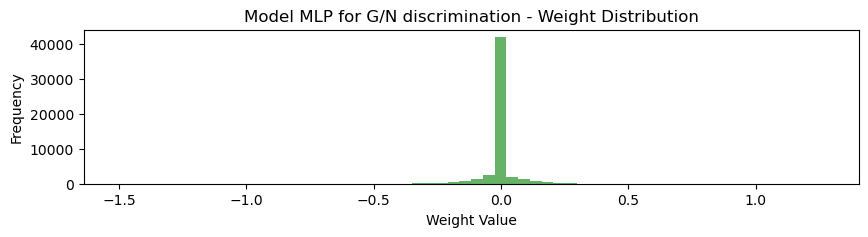

In [88]:
weights = np.concatenate([w.flatten() for w in teacher_model.get_weights()])

plt.figure(figsize=(10,2))
plt.hist(weights, bins=60, color='green', alpha=0.6)
plt.xlabel("Weight Value")
plt.ylabel("Frequency")
plt.title("Model MLP for G/N discrimination - Weight Distribution")
plt.show()

# Pruning 

In [89]:
epochs = 1
lr = 0.01
loss = 'categorical_crossentropy'
op = Adam(lr)
metrics = ['accuracy']
batch = 16
val_split = 0.2

final_sparsity = 0.5

pruning_params = {
                'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
                initial_sparsity=0, final_sparsity=final_sparsity, begin_step=0, end_step=1000
                )
            }

callbacks.append(pruning_callbacks.UpdatePruningStep())

In [ ]:
modelP = tfmot.sparsity.keras.prune_low_magnitude(teacher_model, **pruning_params)

modelP.compile(optimizer=op, keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=metrics)

ValueError: `prune_low_magnitude` can only prune an object of the following types: keras.models.Sequential, keras functional model, keras.layers.Layer, list of keras.layers.Layer. You passed an object of type: Sequential.